# 气温预测

In [50]:
%%bash
gdown https://drive.google.com/uc?id=1y_1Lg-BbcepJqZaLhrRU04hMUCvzzy-Z

Downloading...
From: https://drive.google.com/uc?id=1y_1Lg-BbcepJqZaLhrRU04hMUCvzzy-Z
To: /content/temps.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 16.2MB/s]


In [51]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
# 魔法函数，内嵌画图
%matplotlib inline  

## 读取数据

In [52]:
features = pd.read_csv('temps.csv')

# 看一下数据的样子
features.head()

# temp_2 前2天的温度
# temp_1 前1天的温度
# friend 朋友瞎猜的

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [53]:
print('数据维度：', features.shape)

数据维度： (348, 9)


## 把数据画出来看看

In [54]:
### 复制粘贴的
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [55]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

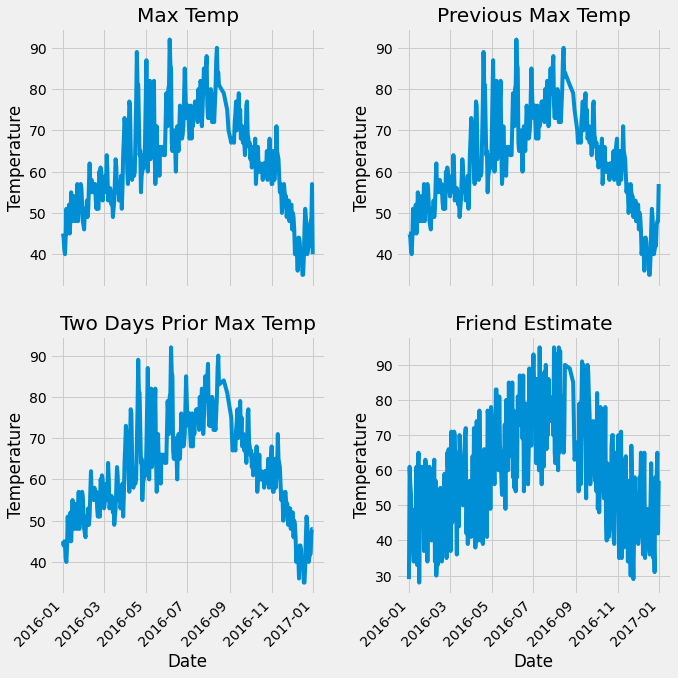

In [56]:
### 复制粘贴的
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

## 数据预处理

In [57]:
# 将周几的字符串转换为one-hot编码
features = pd.get_dummies(features)
features.head(7)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0
5,2016,1,6,40,44,46.1,51,40,0,0,0,0,0,0,1
6,2016,1,7,44,51,46.2,45,38,0,0,0,0,1,0,0


In [58]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签,axis=1表示删除列，inplace=True表示在原数据上操作
features.drop('actual', axis=1, inplace=True)
features.head()

# 名字单独保存以下，以备后患
features_list = list(features.columns)
print(features_list[0])

# 将数据转换成ndarray格式
features = np.array(features)
features[0]

year


array([2.016e+03, 1.000e+00, 1.000e+00, 4.500e+01, 4.500e+01, 4.560e+01,
       2.900e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

In [59]:
features.shape

(348, 14)

In [60]:
# 特征缩放到均值为0，方差为1
# https://www.zhihu.com/question/20467170

from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [61]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

## 构建网络模型

In [62]:
x = torch.tensor(input_features, dtype=float)
y = torch.tensor(labels, dtype=float)

# 权重参数初始化
weights = torch.randn((14,128), dtype=float, requires_grad=True)
bias = torch.randn(128, dtype=float, requires_grad=True)
weights2 = torch.randn((128,1), dtype=float, requires_grad=True)
bias2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []

for i in range(1000):
  # 计算隐层
  hidden = x.mm(weights) + bias
  # 加入激活函数
  hidden = torch.relu(hidden)
  # 预测结果
  predictions = hidden.mm(weights2) + bias2
  # 计算损失
  loss = torch.mean((predictions - y) ** 2)
  losses.append(loss.data.numpy())

  # 打印损失值
  if i % 100 == 0:
    print('loss:', loss)
  # 反向传播计算
  loss.backward()

  # 更新参数
  weights.data.add_(- learning_rate * weights.grad.data)
  bias.data.add_(- learning_rate * bias.grad.data)
  weights2.data.add_(- learning_rate * weights2.grad.data)
  bias2.data.add_(- learning_rate * bias2.grad.data)

  # 每次迭代清空梯度值
  weights.grad.data.zero_()
  bias.grad.data.zero_()
  weights2.grad.data.zero_()
  bias2.grad.data.zero_()


loss: tensor(3547.1327, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(156.7848, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(148.5419, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(145.5111, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.8893, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.8643, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.1532, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.6383, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.2552, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.9577, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [63]:
predictions.shape

torch.Size([348, 1])

## 更简单的构建网络模型

In [64]:
input_size = input_features.shape[1]    # 14
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [65]:
# 训练网络
losses = []
for i in range(1000):
  batch_loss = []
  # mini-batch方法训练
  for start in range(0, len(input_features), batch_size):
    if start + batch_size < len(input_features):
      end = start + batch_size
    else:
      end = len(input_features)
  
    xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
    yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
    prediction = my_nn(xx)
    loss = cost(prediction, yy)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    batch_loss.append(loss.data.numpy())

  # 打印损失
  if i % 100 == 0:
    losses.append(np.mean(batch_loss))
    print('iteration:',i,'\t','loss:',losses[-1])

iteration: 0 	 loss: 3898.714
iteration: 100 	 loss: 37.636086
iteration: 200 	 loss: 35.626747
iteration: 300 	 loss: 35.278934
iteration: 400 	 loss: 35.11903
iteration: 500 	 loss: 34.99023
iteration: 600 	 loss: 34.872868
iteration: 700 	 loss: 34.755135
iteration: 800 	 loss: 34.632828
iteration: 900 	 loss: 34.506107


In [66]:
# 预测结果
x = torch.tensor(input_features, dtype = torch.float)
prediction = my_nn(x).data.numpy()
prediction.shape

(348, 1)

In [67]:
### 复制粘贴的
# 展示结果
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, features_list.index('month')]
days = features[:, features_list.index('day')]
years = features[:, features_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': prediction.reshape(-1)}) # reshape(-1)，返回新的ndarray数据，维度为1

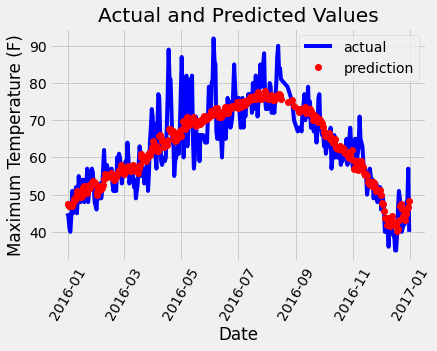

In [68]:
### 复制粘贴的
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


# Mnist分类任务

In [69]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 下载数据

In [70]:
### 复制粘贴的，建文件夹
from pathlib import Path
import requests
import os

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [71]:
# 下载数据
%%bash
cd /content/data/mnist
gdown https://drive.google.com/uc?id=1TfXil8_L08ZnVJtO0bmVldxMbzdyTjnq

Downloading...
From: https://drive.google.com/uc?id=1TfXil8_L08ZnVJtO0bmVldxMbzdyTjnq
To: /content/data/mnist/mnist.pkl.gz
100%|██████████| 16.2M/16.2M [00:00<00:00, 197MB/s]


In [72]:
# 解压加载数据
import pickle
import gzip

with gzip.open((PATH / "mnist.pkl.gz").as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

<class 'numpy.ndarray'> 

(50000, 784) 

(50000,) 

(10000, 784) 

(10000,) 



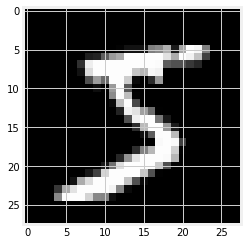

In [73]:
# 数据基本情况
# 图像大小为28*28=784， train 50000张， valid 10000张
print(type(x_train), '\n')
print(x_train.shape, '\n')
print(y_train.shape, '\n')
print(x_valid.shape, '\n')
print(y_valid.shape, '\n')

from matplotlib import pyplot
import numpy as np
pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")

In [74]:
# 数据转换成tensor格式

import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
print(type(x_train))
print(y_train.min())
print(y_train.max())

<class 'torch.Tensor'>
tensor(0)
tensor(9)


## torch.nn.functional

nn.functional有很多的函数，有些与nn.Module重复

一般，如果模型有可学习参数，用nn.Module

其他情况，用nn.functional相对简单

In [75]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb.mm(weights) + bias

In [76]:
batch_size = 64
xb = x_train[0:batch_size]
yb = y_train[0:batch_size]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.randn(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(15.5946, grad_fn=<NllLossBackward0>)


## 继承torch.nn.Module构建网络

- 必须继承nn.Module且在其构造函数中中调用nn.Module的构造函数
- 无需写反向传播，利用autograd机制自动实现
- 无需写weights/bias的初始值，自动就生成了
- Module中可学习的参数可以通过named_parameters()或者parameters()返回迭代器

In [77]:
# 写网络的架构
from torch import nn

class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784, 128)
    self.hidden2 = nn.Linear(128, 256)
    self.out = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = self.out(x)
    return x

In [78]:
# 实例化
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [79]:
# 打印c层名、权重和偏置
for name, parameter in net.named_parameters():
  print(name, parameter)

hidden1.weight Parameter containing:
tensor([[ 0.0153,  0.0210, -0.0232,  ...,  0.0352,  0.0003,  0.0277],
        [-0.0148,  0.0333,  0.0044,  ..., -0.0024,  0.0293, -0.0213],
        [ 0.0329,  0.0118, -0.0094,  ...,  0.0032, -0.0109,  0.0100],
        ...,
        [-0.0303,  0.0080, -0.0324,  ..., -0.0013, -0.0186,  0.0150],
        [-0.0090, -0.0237,  0.0142,  ...,  0.0152,  0.0150, -0.0048],
        [-0.0065,  0.0183,  0.0083,  ...,  0.0072, -0.0272,  0.0186]],
       requires_grad=True)
hidden1.bias Parameter containing:
tensor([-0.0204, -0.0025,  0.0100, -0.0140,  0.0188,  0.0176,  0.0135,  0.0356,
        -0.0033, -0.0149,  0.0029, -0.0172,  0.0177, -0.0107, -0.0110, -0.0040,
        -0.0022, -0.0151, -0.0118,  0.0250, -0.0061,  0.0077, -0.0344, -0.0127,
        -0.0322,  0.0037, -0.0104, -0.0046, -0.0228, -0.0008,  0.0091,  0.0108,
         0.0093,  0.0216, -0.0302, -0.0220,  0.0269, -0.0133, -0.0136, -0.0251,
        -0.0054, -0.0057,  0.0171, -0.0250,  0.0312,  0.0024,  0.02

## 使用TensorDataset和Dataloader加载数据

TensorDataset() 类似于python内置的zip函数,括号里面的需要是tensor格式，一般第一个是数据，第二个是标签

DataLoader() 括号里面的需要是TensorDataset包装好的东西

参数说明参考链接：https://blog.csdn.net/qq_39507748/article/details/105385709 

读取数据参考链接：https://zhuanlan.zhihu.com/p/379428892

In [80]:
### 学习使用TensorDataset与DataLoader

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

print("数据与标签的形状：", x_train.shape, y_train.shape)

# 使用TensorDataset打包数据集
train_DS = TensorDataset(x_train, y_train)
print("train_DS里的第0个和第1个数据：", train_DS[0], '\n', train_DS[1])
print("train_DS的数据个数", len(train_DS))

# 使用DataLoader加载数据集，返回一个迭代器，包含了一个epoch的数据
train_DL = DataLoader(train_DS, batch_size=1, shuffle=False)

for i,data in enumerate(train_DL):
	# i表示第几个batch， data表示该batch对应的数据，包含数据和对应的标签
  print("第 {} 个Batch \n{}".format(i, data))
  if i==1:
    break

数据与标签的形状： torch.Size([50000, 784]) torch.Size([50000])
train_DS里的第0个和第1个数据： (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [81]:
# 加载数据

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_DS = TensorDataset(x_train, y_train)
valid_DS = TensorDataset(x_valid, y_valid)

train_DL = DataLoader(train_DS, batch_size=64, shuffle=True)
valid_DL = DataLoader(valid_DS, batch_size=64, shuffle=False)

## 训练与测试

In [82]:
from torch import optim
import torch.nn.functional as F

model = Mnist_NN()
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = F.cross_entropy
epochs = 25

def train():
  for epoch in range(epochs):
    model.train()
    for xb,yb in train_DL:
      loss = loss_func(model(xb), yb)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    

    model.eval()
    with torch.no_grad():
      losses = 0
      nums = 0
      for xb,yb in valid_DL:
        loss = loss_func(model(xb), yb)
        losses += loss
        nums += len(yb)
      print("epoch{}: 训练集损失为 {:.2f}".format(epoch, losses/nums))

In [83]:
train()

epoch0: 训练集损失为 0.04
epoch1: 训练集损失为 0.04
epoch2: 训练集损失为 0.03
epoch3: 训练集损失为 0.03
epoch4: 训练集损失为 0.03
epoch5: 训练集损失为 0.03
epoch6: 训练集损失为 0.02
epoch7: 训练集损失为 0.02
epoch8: 训练集损失为 0.02
epoch9: 训练集损失为 0.01
epoch10: 训练集损失为 0.01
epoch11: 训练集损失为 0.01
epoch12: 训练集损失为 0.01
epoch13: 训练集损失为 0.01
epoch14: 训练集损失为 0.01
epoch15: 训练集损失为 0.01
epoch16: 训练集损失为 0.01
epoch17: 训练集损失为 0.01
epoch18: 训练集损失为 0.01
epoch19: 训练集损失为 0.01
epoch20: 训练集损失为 0.01
epoch21: 训练集损失为 0.01
epoch22: 训练集损失为 0.01
epoch23: 训练集损失为 0.01
epoch24: 训练集损失为 0.01


In [85]:
# 输出一个batch的预测值和真值
for xb,yb in valid_DL:
  predictions = model(xb).data.numpy().tolist()
  result=[]
  for i in predictions:
    max_index = i.index(max(i))
    result.append(max_index)

  print(len(predictions))
  print(result)
  print(yb.data.numpy().tolist())
  break

64
[3, 8, 6, 9, 6, 4, 5, 5, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 5, 0, 6, 2, 9, 9, 4, 1, 5, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 6, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1]
[3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1]
